Use this first cell to import the necessary libraries.

In [60]:
# IMport Lib
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Counter
import torch.nn as nn
import math
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# 1. **Data Management**



1.   experimental protocol (such as k-fold, cross validation, etc);
2.	create the dataloader to load the data.



In [2]:
# Define the experimental protocol
# Set the random seed to ensure experimental reproducibility
torch.manual_seed(42)
np.random.seed(42)

Data = "assignment3-ner_dataset.txt"
BatchSize = 32
Maxlen = 150

def DataLoad(Data):
  Sentences = []
  ActorSentences = []
  try:
    with open(Data, "r", encoding="utf-8") as F:
      for line in F:
        line = line.strip()
        if line:
          Word, Label = line.strip().split()
          ActorSentences.append((Word, Label))
        else:
          if ActorSentences:
            Sentences.append(ActorSentences)
            ActorSentences = []
      if ActorSentences:
        Sentences.append(ActorSentences)
    return Sentences
  except FileNotFoundError:
    raise FileNotFoundError(f"File {Data} does not exist!!!")
  except ValueError:
    raise ValueError(f"Invalid data format in file {Data}")

def BuildData(Sentences):
  CountWords = Counter(Word for Sentence in Sentences for Word, _ in Sentence)
  WordId = {"<PAD>":0, "<UNK>":1}
  for Word, _ in CountWords.items():
    WordId[Word] = len(WordId)

  AllLabels = set(Label for Sentence in Sentences for _, Label in Sentence)
  LabelId = {"<PAD>":0}
  for Label in sorted(AllLabels):
    LabelId[Label]=len(LabelId)
  IdLabel = {Idx: Label for Label, Idx in LabelId.items()}
  return WordId, LabelId, IdLabel

class MyDataset(Dataset):
  def __init__(self, Sentences, WordId, LabelId, Maxlen=150):
    self.Sentences = Sentences
    self.Word = WordId
    self.Label = LabelId
    self.Maxlen = Maxlen
    self.data = []
    for Sentence in Sentences:
      Words = [WordId.get(Word, WordId["<UNK>"]) for Word, _ in Sentence[:self.Maxlen]]
      Labels = [LabelId[Label] for _, Label in Sentence[:Maxlen]]
      self.data.append((Words, Labels))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, Idx):
    Words, Labels = self.data[Idx]
    Length = len(Words)
    return torch.tensor(Words, dtype=torch.long), torch.tensor(Labels, dtype=torch.long), Length

def DataLoading(Sentences, WordId, LabelId, BatchSize, Maxlen=150, shuffle=True):
  Dataset = MyDataset(Sentences, WordId, LabelId, Maxlen)
  def Filling(Batch):
    if not Batch:
      raise ValueError("Empty batch received in Filling function.")
    Words, Labels, Lengths = zip(*Batch)
    MaxlenBatch = min(max(Lengths), Maxlen)
    PadWords = torch.zeros(len(Batch), MaxlenBatch, dtype=torch.long)
    PadLabels = torch.zeros(len(Batch), MaxlenBatch, dtype=torch.long)
    for i, (WordX, LabelX) in enumerate(zip(Words, Labels)):
      Length = min(len(WordX), MaxlenBatch)
      PadWords[i, :Length] = WordX[:Length]
      PadLabels[i, :Length] = LabelX[:Length]
    Mask=(PadWords != 0)
    return PadWords, PadLabels, torch.tensor(Lengths, dtype=torch.long), Mask
  dataLoader = DataLoader(Dataset, batch_size=BatchSize, shuffle=shuffle, collate_fn=Filling)
  return dataLoader

# Testing
if __name__ == "__main__":
    try:
      Sentences = DataLoad(Data)
      print(f"Number of sentences: {len(Sentences)}")
      for word, label in Sentences[0]:
        print(f"  ({word}, {label})")
      WordId, LabelId, IdLabel = BuildData(Sentences)
      print(f"WordId: {len(WordId)}")
      print(f"LabelId: {len(LabelId)}")
      print(f"LabelId reflect: {LabelId}")
      print(f"IdLabel reflect: {IdLabel}")

      LengthCounts = Counter(len(Sentence) for Sentence in Sentences)
      print("Sentence length distribution:")
      max_len = max(len(Sentence) for Sentence in Sentences)
      bins = [0, 20, 40, 60, 80, 100, 120, 150, max_len + 1]
      for i in range(len(bins) - 1):
        count = sum(v for k, v in LengthCounts.items() if bins[i] < k <= bins[i+1])
        print(f"Length {bins[i]+1}-{bins[i+1]}: {count} sentences")

      label_counts = Counter(Label for Sentence in Sentences for _, Label in Sentence)
      print("Label distribution:", label_counts)

      empty_sentences = [i for i, s in enumerate(Sentences) if not s]
      if empty_sentences:
        print(f"Warning: Found empty sentences at indices: {empty_sentences}")
    except FileNotFoundError:
      print(f"Error: File {Data} does not exist, please check the path.")
    except Exception as e:
      print(f"Runtime Error: {str(e)}")


Number of sentences: 1696
  (010, I-MISC)
  (is, O)
  (the, O)
  (tenth, O)
  (album, O)
  (from, O)
  (Japanese, I-MISC)
  (Punk, O)
  (Techno, O)
  (band, O)
  (The, I-ORG)
  (Mad, I-ORG)
  (Capsule, I-ORG)
  (Markets, I-ORG)
  (., O)
WordId: 8506
LabelId: 6
LabelId reflect: {'<PAD>': 0, 'I-LOC': 1, 'I-MISC': 2, 'I-ORG': 3, 'I-PER': 4, 'O': 5}
IdLabel reflect: {0: '<PAD>', 1: 'I-LOC', 2: 'I-MISC', 3: 'I-ORG', 4: 'I-PER', 5: 'O'}
Sentence length distribution:
Length 1-20: 858 sentences
Length 21-40: 679 sentences
Length 41-60: 131 sentences
Length 61-80: 23 sentences
Length 81-100: 4 sentences
Length 101-120: 0 sentences
Length 121-150: 1 sentences
Length 151-145: 0 sentences
Label distribution: Counter({'O': 32576, 'I-ORG': 1958, 'I-PER': 1634, 'I-LOC': 1447, 'I-MISC': 1392})


In [3]:
def MainLabel(Sentence, LabelId):
  if not Sentence:
    return LabelId['O']
  Labels = [Label for _,Label in Sentence if Label!='O']
  return LabelId[Labels[0]] if Labels else LabelId['O']

def KFoldData(Data, BatchSize, Maxlen=150):
  Sentences = DataLoad(Data)
  if not Sentences:
    raise ValueError("No sentences loaded from the dataset.")

  WordId, LabelId, IdLabel = BuildData(Sentences)
  MainLabels = [MainLabel(S, LabelId) for S in Sentences]

  TrainValIdx, TestIdx=train_test_split(range(len(Sentences)),test_size=0.2,
                                        stratify=MainLabels,random_state=42)

  TrainValSentences = [Sentences[i] for i in TrainValIdx]
  TestSentences = [Sentences[i] for i in TestIdx]
  TrainValLabels = [MainLabels[i] for i in TrainValIdx]

  SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  KFoldDataList = []
  for TrainIdx, ValIdx in SKF.split(TrainValSentences, TrainValLabels):
    FoldTrain = [TrainValSentences[i] for i in TrainIdx]
    FoldVal = [TrainValSentences[i] for i in ValIdx]
    TrainDataLoader = DataLoading(FoldTrain, WordId, LabelId, BatchSize, Maxlen, shuffle=True)
    ValDataLoader = DataLoading(FoldVal, WordId, LabelId, BatchSize, Maxlen, shuffle=False)
    KFoldDataList.append((TrainDataLoader, ValDataLoader))
  TestDataLoader = DataLoading(TestSentences, WordId, LabelId, BatchSize, Maxlen, shuffle=False)
  return KFoldDataList, TestDataLoader, WordId, LabelId, IdLabel

# Testing
if __name__ == "__main__":
    try:
        KFoldDataList, TestDataLoader, WordId, LabelId, IdLabel = KFoldData(Data, BatchSize)
        Sentences = DataLoad(Data)
        TestSentences = TestDataLoader.dataset.Sentences
        TrainDataLoader, ValDataLoader = KFoldDataList[0]
        
        print("Split Statistics:")
        print(f"Test Set: {len(TestSentences)}")
        test_label_counts = Counter(label for sentence in TestSentences for _, label in sentence)
        print(f"Test set label distribution: {test_label_counts}")
        for fold, (TrainDataLoader, ValDataLoader) in enumerate(KFoldDataList, 1):
            TrainSentences = TrainDataLoader.dataset.Sentences
            ValSentences = ValDataLoader.dataset.Sentences
            print(f"Fold{fold}:")
            print(f"  Training set: {len(TrainSentences)}")
            print(f"  Validation set: {len(ValSentences)}")
            train_label_counts = Counter(label for sentence in TrainSentences for _, label in sentence)
            val_label_counts = Counter(label for sentence in ValSentences for _, label in sentence)
            print(f"  Training set label distribution: {train_label_counts}")
            print(f"  Validation set label distribution: {val_label_counts}")

        print("Test TrainDataLoader (First Fold):")
        for i, (PadWords, PadLabels, Lengths, Mask) in enumerate(TrainDataLoader):
            print(f"Batch {i + 1}:")
            print(f"PadWords shape: {PadWords.shape}")
            print(f"PadLabels shape: {PadLabels.shape}")
            print(f"Mask shape: {Mask.shape}")
            print(f"Lengths shape: {Lengths.shape}")
            break

        print("Test ValDataLoader (First Fold):")
        for i, (PadWords, PadLabels, Lengths, Mask) in enumerate(ValDataLoader):
            print(f"Batch {i + 1}:")
            print(f"PadWords shape: {PadWords.shape}")
            print(f"PadLabels shape: {PadLabels.shape}")
            print(f"Mask shape: {Mask.shape}")
            print(f"Lengths shape: {Lengths.shape}")
            break

        print("Test TestDataLoader:")
        for i, (PadWords, PadLabels, Lengths, Mask) in enumerate(TestDataLoader):
            print(f"Batch {i + 1}:")
            print(f"PadWords shape: {PadWords.shape}")
            print(f"PadLabels shape: {PadLabels.shape}")
            print(f"Mask shape: {Mask.shape}")
            print(f"Lengths shape: {Lengths.shape}")
            break

    except FileNotFoundError:
        print(f"Error: File {Data} does not exist, please check the path.")
    except Exception as e:
        print(f"Runtime Error: {str(e)}")


Split Statistics:
Test Set: 340
Test set label distribution: Counter({'O': 6573, 'I-ORG': 400, 'I-PER': 314, 'I-LOC': 306, 'I-MISC': 293})
Fold1:
  Training set: 1084
  Validation set: 272
  Training set label distribution: Counter({'O': 20788, 'I-ORG': 1268, 'I-PER': 1057, 'I-LOC': 904, 'I-MISC': 898})
  Validation set label distribution: Counter({'O': 5215, 'I-ORG': 290, 'I-PER': 263, 'I-LOC': 237, 'I-MISC': 201})
Fold2:
  Training set: 1085
  Validation set: 271
  Training set label distribution: Counter({'O': 21049, 'I-ORG': 1229, 'I-PER': 1049, 'I-LOC': 892, 'I-MISC': 855})
  Validation set label distribution: Counter({'O': 4954, 'I-ORG': 329, 'I-PER': 271, 'I-LOC': 249, 'I-MISC': 244})
Fold3:
  Training set: 1085
  Validation set: 271
  Training set label distribution: Counter({'O': 20887, 'I-ORG': 1256, 'I-PER': 1069, 'I-LOC': 917, 'I-MISC': 873})
  Validation set label distribution: Counter({'O': 5116, 'I-ORG': 302, 'I-PER': 251, 'I-MISC': 226, 'I-LOC': 224})
Fold4:
  Training 

---

# 2. **Neural Networks**


1.	create a Recurrent Neural Network (RNN) (such as RNN, GRU, LSTM) to tackle the problem;
2.	create a Transformer Network to tackle the problem;
3.	define the necessary components to train the networks (that is, loss function, optimizers, etc);
4.	train the models;
5.	for all training procedures, separately plot the loss and accuracy with respect to the epoch/iteration.

Using device: cuda
Final Result:
Fold 1: Train Loss=0.1049,Val Loss=0.4067, Test Loss=0.4370, Train Acc=0.9658, Val Acc=0.8912, Test Acc=0.8828


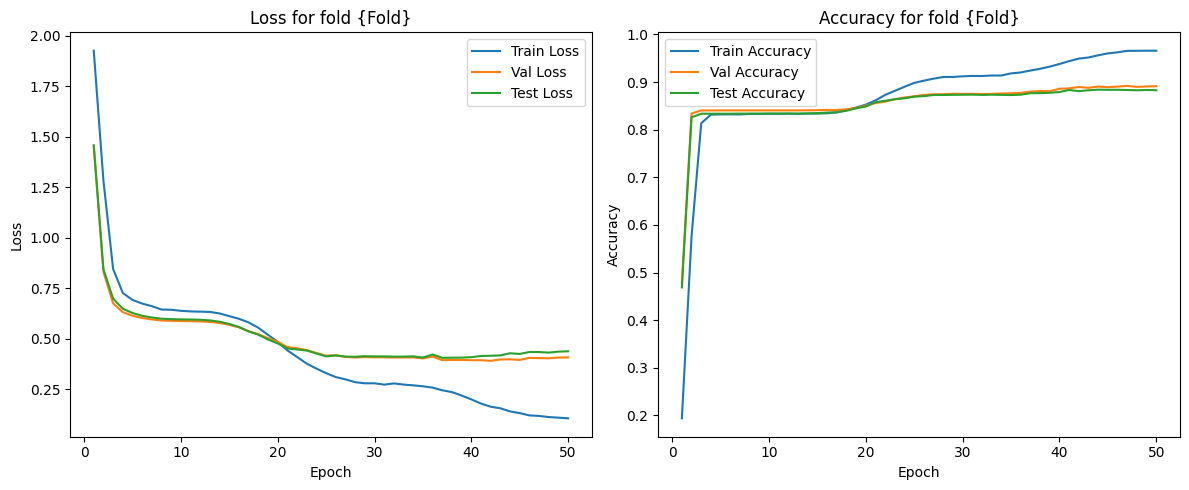

Final Result:
Fold 2: Train Loss=0.1085,Val Loss=0.5179, Test Loss=0.4486, Train Acc=0.9657, Val Acc=0.8780, Test Acc=0.8906


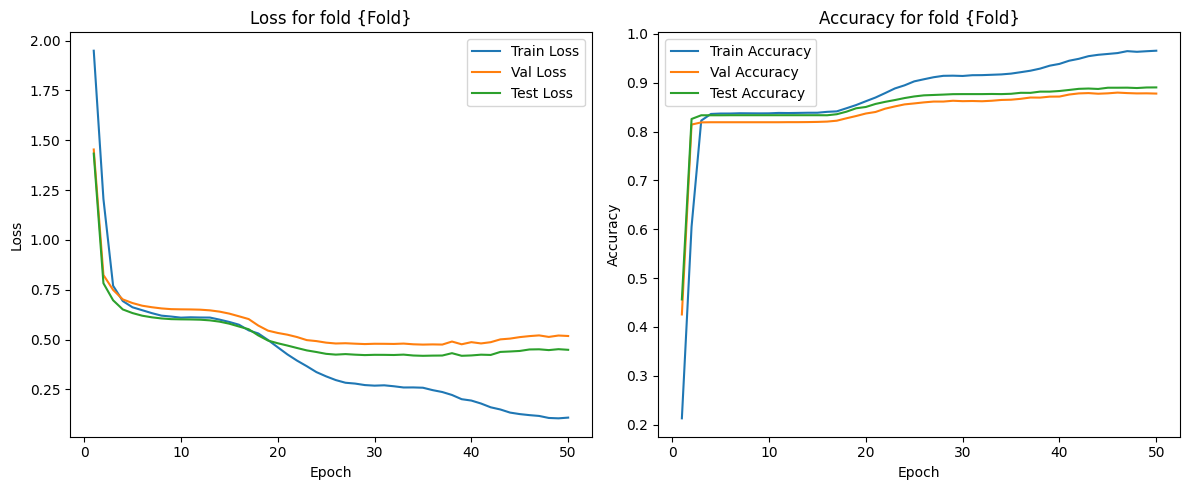

Final Result:
Fold 3: Train Loss=0.1065,Val Loss=0.4403, Test Loss=0.4488, Train Acc=0.9656, Val Acc=0.8899, Test Acc=0.8893


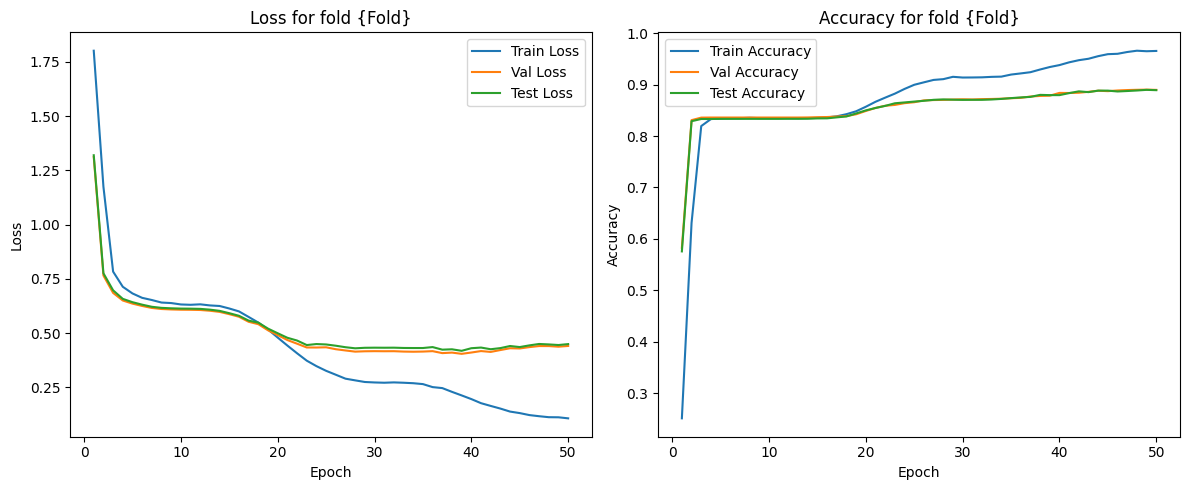

Final Result:
Fold 4: Train Loss=0.1014,Val Loss=0.4714, Test Loss=0.4472, Train Acc=0.9665, Val Acc=0.8889, Test Acc=0.8890


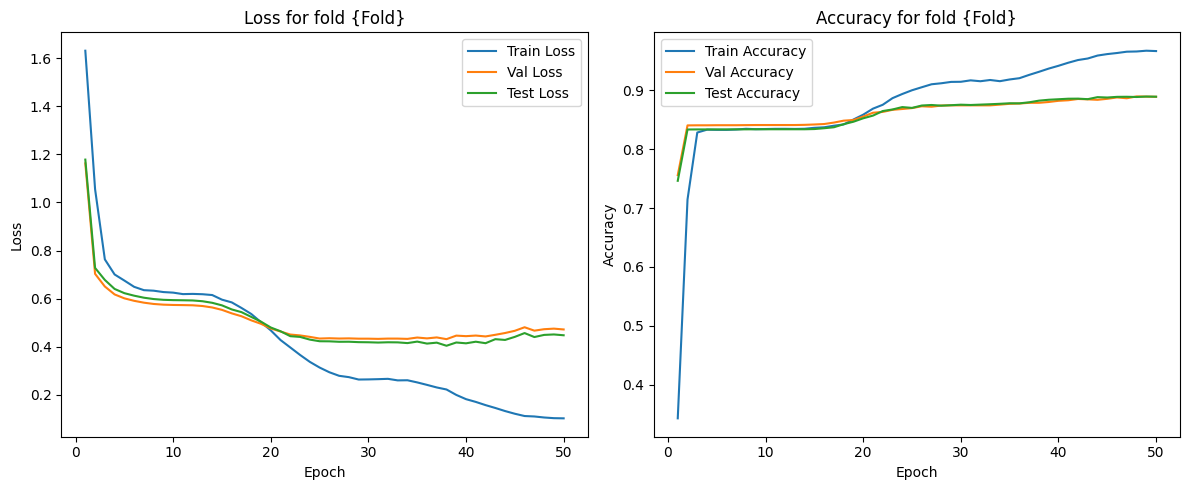

Final Result:
Fold 5: Train Loss=0.1093,Val Loss=0.4776, Test Loss=0.4438, Train Acc=0.9641, Val Acc=0.8912, Test Acc=0.8899


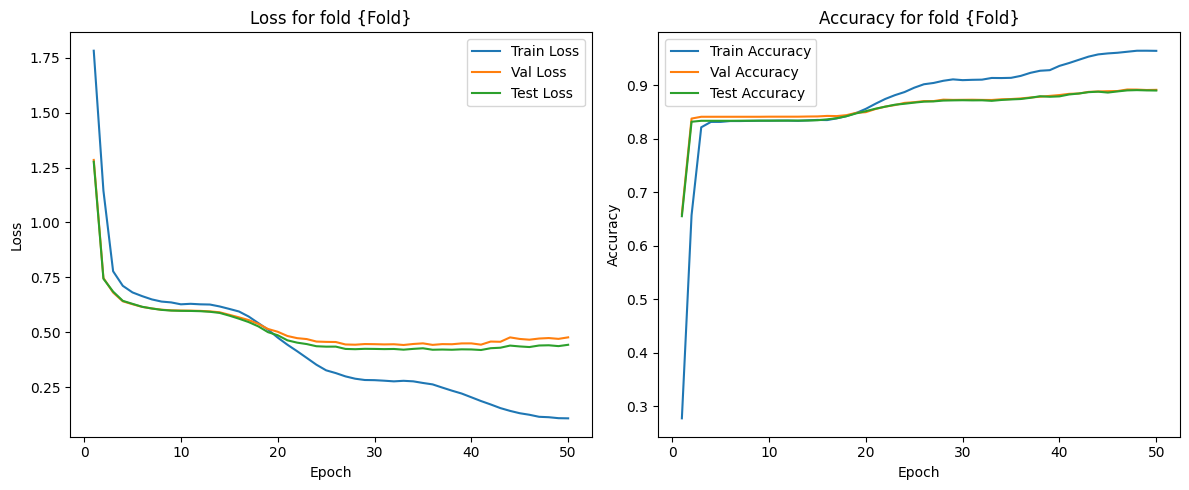

In [99]:
# Set Parameters
EmbeddingDim = 200
HiddenDim = 128
NumEpochs = 50
LR = 5e-4

# BiLSTM Implement
class BiLSTM(nn.Module):
  def __init__(self, WordSize, TagSize, EmbeddingDim, HiddenDim):
    super(BiLSTM, self).__init__()
    self.Embedding = nn.Embedding(WordSize, EmbeddingDim, padding_idx=0)
    self.LSTM = nn.LSTM(EmbeddingDim, HiddenDim // 2,num_layers=2, bidirectional=True, batch_first=True, dropout=0.3)
    self.Dropout = nn.Dropout(0.5)
    self.HiddenTag = nn.Linear(HiddenDim, TagSize)
    self.LayerNorm = nn.LayerNorm(HiddenDim)

  def forward(self, Sentences, Lengths):
    Embedded = self.Embedding(Sentences)
    Packed = nn.utils.rnn.pack_padded_sequence(Embedded, Lengths, batch_first=True, enforce_sorted=False)
    LSTMOut, _ = self.LSTM(Packed)
    LSTMOut, _ = nn.utils.rnn.pad_packed_sequence(LSTMOut, batch_first=True)
    LSTMOut = self.LayerNorm(LSTMOut)
    LSTMOut = self.Dropout(LSTMOut)
    Emissions = self.HiddenTag(LSTMOut)
    return Emissions

  def Loss(self, Sentences, Tags, Lengths):
    Emissions = self.forward(Sentences, Lengths)
    Mask = (Sentences != 0).float()
    Loss = nn.CrossEntropyLoss(ignore_index=0)
    return Loss(Emissions.view(-1, Emissions.shape[-1]), Tags.view(-1))

  def Predict(self, Sentences, Lengths):
    Emissions = self.forward(Sentences, Lengths)
    _, Preds = torch.max(Emissions, dim=2)
    return Preds

def TrainModel(Model, TrainDataLoader, ValDataLoader, TestDataLoader, NumEpochs, Device):
  Optimizer = torch.optim.RAdam(Model.parameters(), lr=LR, weight_decay=8e-4)
  Scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(Optimizer, T_max=10, eta_min=1e-5)
  TrainLosses, ValLosses, TestLosses = [], [], []
  TrainAccs, ValAccs, TestAccs = [], [], []

  for Epoch in range(NumEpochs):
    Model.train()
    TotalLoss = 0
    Correct = 0
    Total = 0
    for PadWords, PadLabels, Lengths, Mask in TrainDataLoader:
      PadWords, PadLabels = PadWords.to(Device), PadLabels.to(Device)

      Optimizer.zero_grad()
      Loss = Model.Loss(PadWords, PadLabels, Lengths)
      Loss.backward()
      torch.nn.utils.clip_grad_norm_(Model.parameters(), max_norm=1.0)
      Optimizer.step()
      TotalLoss += Loss.item()
      Preds = Model.Predict(PadWords, Lengths)
      Mask = (PadWords != 0)
      Correct += ((Preds == PadLabels) * Mask).sum().item()
      Total += Mask.sum().item()

    AvgTrainLoss = TotalLoss / len(TrainDataLoader)
    AvgTrainAcc = Correct / Total
    TrainLosses.append(AvgTrainLoss)
    TrainAccs.append(AvgTrainAcc)

    Model.eval()
    TotalLoss = 0
    Correct = 0
    Total = 0
    with torch.no_grad():
      for PadWords, PadLabels, Lengths, Mask in ValDataLoader:
        PadWords, PadLabels = PadWords.to(Device), PadLabels.to(Device)
        Loss = Model.Loss(PadWords, PadLabels, Lengths)
        TotalLoss += Loss.item()
        Preds = Model.Predict(PadWords, Lengths)
        Mask = (PadWords != 0)
        Correct += ((Preds == PadLabels) * Mask).sum().item()
        Total += Mask.sum().item()

    AvgValLoss = TotalLoss / len(ValDataLoader)
    AvgValAcc = Correct / max(1, Total)
    ValLosses.append(AvgValLoss)
    ValAccs.append(AvgValAcc)

    TotalLoss = 0
    Correct = 0
    Total = 0
    with torch.no_grad():
      for PadWords, PadLabels, Lengths, Mask in TestDataLoader:
        PadWords, PadLabels = PadWords.to(Device), PadLabels.to(Device)
        Loss = Model.Loss(PadWords, PadLabels, Lengths)
        TotalLoss += Loss.item()
        Preds = Model.Predict(PadWords, Lengths)
        Mask = (PadWords != 0)
        Correct += ((Preds == PadLabels) * Mask).sum().item()
        Total += Mask.sum().item()

    AvgTestLoss = TotalLoss / len(TestDataLoader)
    AvgTestAcc = Correct / max(1, Total)
    TestLosses.append(AvgTestLoss)
    TestAccs.append(AvgTestAcc)

    Scheduler.step()

  return TrainLosses, ValLosses, TestLosses, TrainAccs, ValAccs, TestAccs

if __name__ == "__main__":
  Data = "assignment3-ner_dataset.txt"
  BatchSize = 32
  Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using device: {Device}")
  K = 5

  try:
    KFoldDataList, TestDataLoader, WordId, LabelId, IdLabel = KFoldData(Data, BatchSize)
    AllTrainLosses, AllValLosses, AllTestLosses = [], [], []
    AllTrainAccs, AllValAccs, AllTestAccs = [], [], []

    for Fold, (TrainDataLoader, ValDataLoader) in enumerate(KFoldDataList, 1):
      Model = BiLSTM(
          WordSize=len(WordId),
          TagSize=len(LabelId),
          EmbeddingDim=EmbeddingDim,
          HiddenDim=HiddenDim
      ).to(Device)
      TrainLosses, ValLosses, TestLosses, TrainAccs, ValAccs, TestAccs = TrainModel(Model, TrainDataLoader, ValDataLoader, TestDataLoader, NumEpochs, Device)
      AllTrainLosses.append(TrainLosses)
      AllValLosses.append(ValLosses)
      AllTestLosses.append(TestLosses)
      AllTrainAccs.append(TrainAccs)
      AllValAccs.append(ValAccs)
      AllTestAccs.append(TestAccs)
      print("Final Result:")
      print(f"Fold {Fold}: Train Loss={TrainLosses[-1]:.4f},Val Loss={ValLosses[-1]:.4f}, Test Loss={TestLosses[-1]:.4f}, "
            f"Train Acc={TrainAccs[-1]:.4f}, Val Acc={ValAccs[-1]:.4f}, Test Acc={TestAccs[-1]:.4f}")

      Epochs = list(range(1, NumEpochs + 1))
      plt.figure(figsize=(12, 5))
      plt.subplot(1, 2, 1)
      plt.plot(Epochs, TrainLosses, label='Train Loss')
      plt.plot(Epochs, ValLosses, label='Val Loss')
      plt.plot(Epochs, TestLosses, label='Test Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.title('Loss for fold {Fold}')
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.plot(Epochs, TrainAccs, label='Train Accuracy')
      plt.plot(Epochs, ValAccs, label='Val Accuracy')
      plt.plot(Epochs, TestAccs, label='Test Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.title('Accuracy for fold {Fold}')
      plt.legend()
      plt.tight_layout()
      plt.show()
      plt.close()

  except FileNotFoundError:
    print(f"Error: File {Data} does not exist, please check the path.")
  except Exception as e:
    print(f"Runtime Error: {str(e)}")


"""
Transformer
"""

Using device: cuda
Final Result:
Fold 1: Train Loss=0.1740, Val Loss=0.3995, Test Loss=0.4409, Train Acc=0.9481, Val Acc=0.9140, Test Acc=0.9072


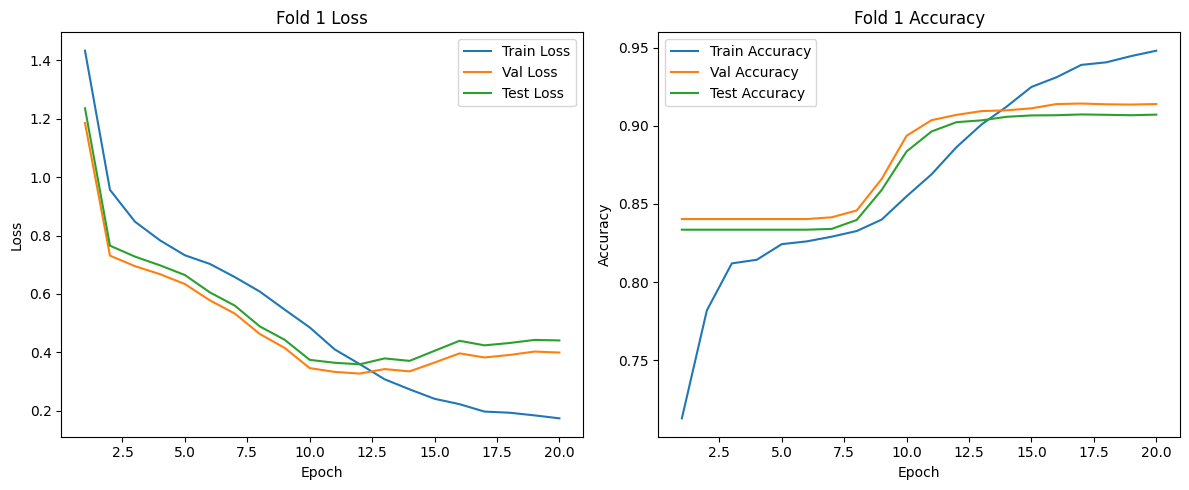

Final Result:
Fold 2: Train Loss=0.1360, Val Loss=0.5327, Test Loss=0.4784, Train Acc=0.9604, Val Acc=0.9001, Test Acc=0.9081


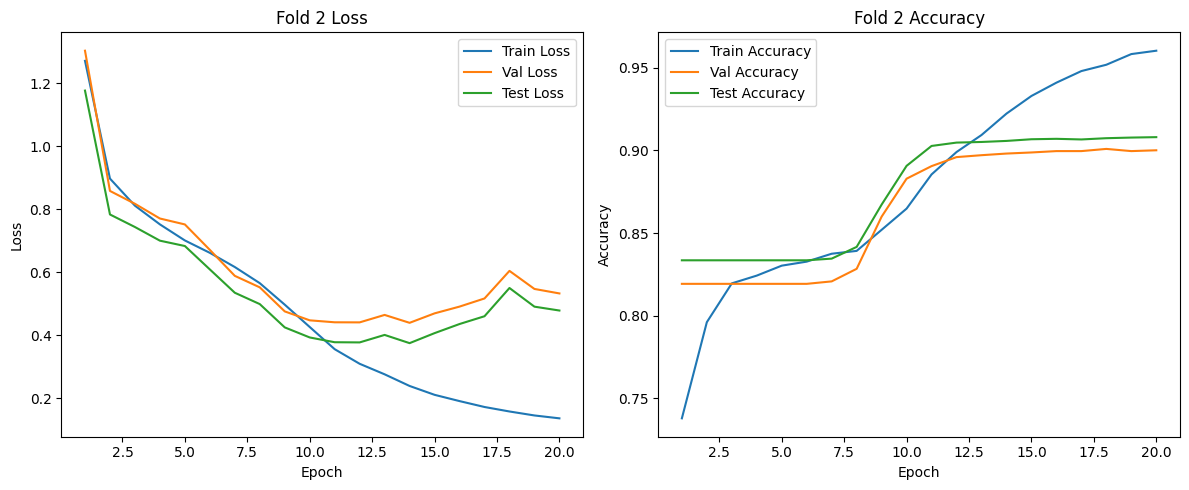

Final Result:
Fold 3: Train Loss=0.1691, Val Loss=0.4874, Test Loss=0.4417, Train Acc=0.9501, Val Acc=0.9047, Test Acc=0.9114


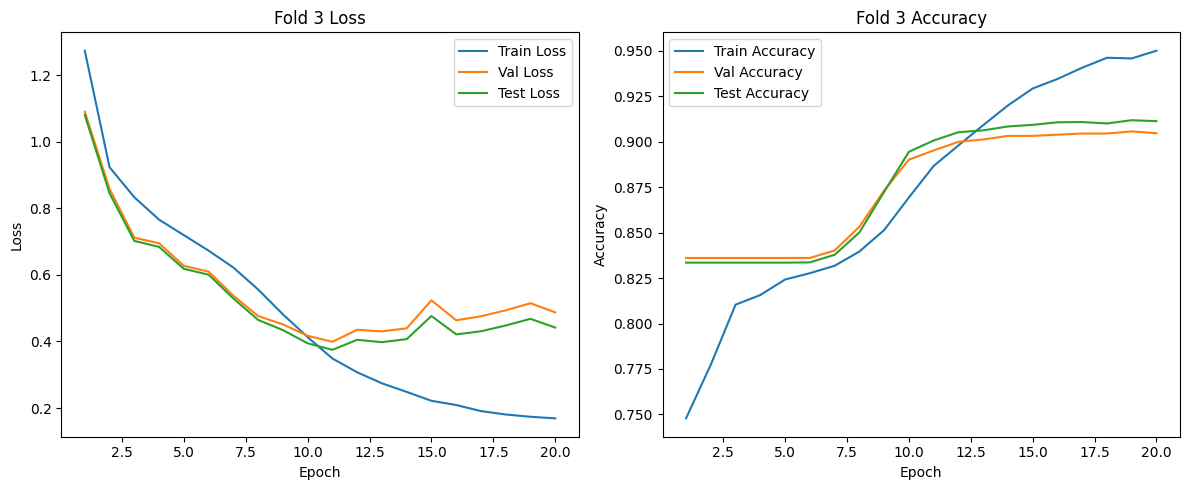

Final Result:
Fold 4: Train Loss=0.1534, Val Loss=0.4466, Test Loss=0.4539, Train Acc=0.9557, Val Acc=0.9130, Test Acc=0.9071


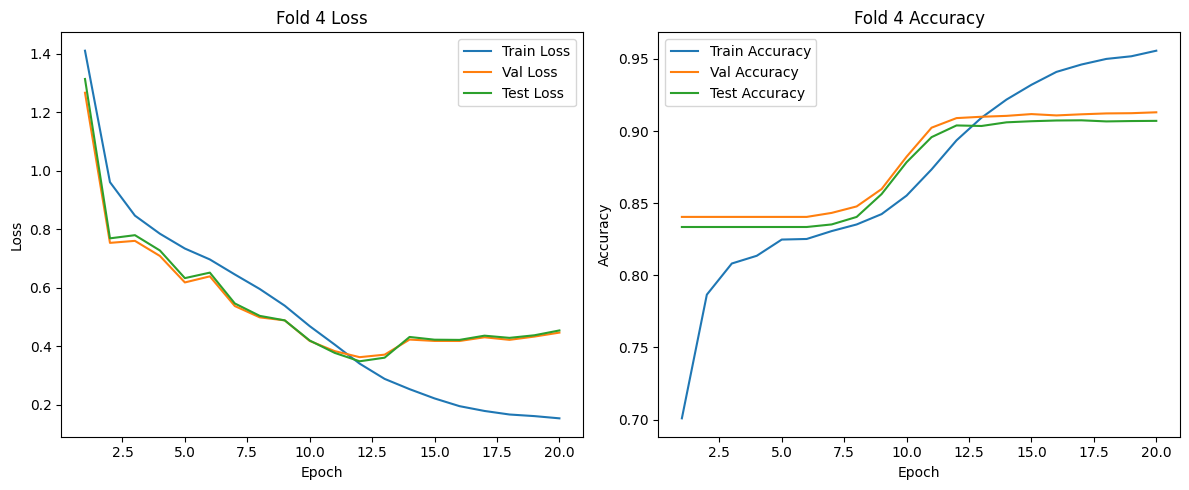

Final Result:
Fold 5: Train Loss=0.1716, Val Loss=0.5067, Test Loss=0.4475, Train Acc=0.9497, Val Acc=0.9100, Test Acc=0.9095


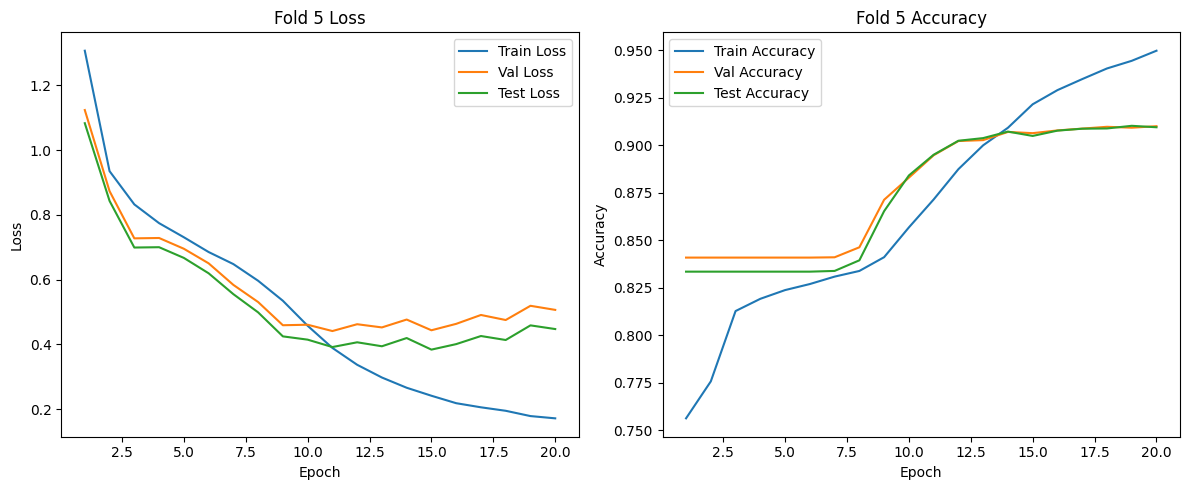

In [49]:
class TransformerNER(nn.Module):
    def __init__(self, WordSize, NumTag, EmbeddingDim=128, NumHeads=4, NumLayers=1, DropOut=0.5, Maxlen=150):
        super(TransformerNER, self).__init__()
        self.Embedding = nn.Embedding(WordSize, EmbeddingDim)
        self.EmbeddingDim = EmbeddingDim
        self.PositionalEncoding = nn.Parameter(torch.zeros(1, Maxlen, EmbeddingDim))
        self.init_positional_encoding(Maxlen, EmbeddingDim)
        EncoderLayer = nn.TransformerEncoderLayer(
            d_model=EmbeddingDim,
            nhead=NumHeads,
            dim_feedforward=EmbeddingDim * 4,
            dropout=DropOut,
            activation='relu',
            batch_first=True
        )
        self.TransformerEncoder = nn.TransformerEncoder(EncoderLayer, NumLayers)
        self.fc = nn.Linear(EmbeddingDim, NumTag)
        self.dropout = nn.Dropout(DropOut)
        self._init_weights()

    def init_positional_encoding(self, Maxlen, EmbeddingDim):
        with torch.no_grad():
            position = torch.arange(0, Maxlen, dtype=torch.float).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, EmbeddingDim, 2).float() * (-math.log(10000.0) / EmbeddingDim))
            self.PositionalEncoding[:, :, 0::2] = torch.sin(position * div_term)
            self.PositionalEncoding[:, :, 1::2] = torch.cos(position * div_term)

    def _init_weights(self):
        nn.init.xavier_uniform_(self.Embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)

    def CreatMask(self, SRC, Lengths):
        Mask = torch.ones(SRC.size(0), SRC.size(1), dtype=torch.bool).to(SRC.device)
        for i, Length in enumerate(Lengths):
            Mask[i, Length:] = 0
        return Mask

    def forward(self, SRC, Lengths):
        BatchSize, Seqlen = SRC.size()

        SRCEmbedding = self.Embedding(SRC) * math.sqrt(self.EmbeddingDim)
        PEncoding = self.PositionalEncoding[:, :Seqlen, :].expand(BatchSize, -1, -1)
        SRCEmbedding = SRCEmbedding + PEncoding.to(SRCEmbedding.device)
        SRCEmbedding = self.dropout(SRCEmbedding)

        Mask = self.CreatMask(SRC, Lengths)

        Output = self.TransformerEncoder(SRCEmbedding, src_key_padding_mask=~Mask)
        Output = self.dropout(Output)
        Output = self.fc(Output)

        return Output

def TrainModel(Model, TrainDataLoader, ValDataLoader, TestDataLoader, Criterion, Optimizer, Scheduler, NumEpochs, Device):
    TrainLosses, ValLosses, TestLosses = [], [], []
    TrainAccs, ValAccs, TestAccs = [], [], []
    BestValAcc = 0.0

    for Epoch in range(NumEpochs):
        Model.train()
        TotalTrainLoss = 0
        Correct, TotalTrain = 0, 0
        for PadWords, PadLabels, Lengths, Mask in TrainDataLoader:
            PadWords, PadLabels = PadWords.to(Device), PadLabels.to(Device)
            Optimizer.zero_grad()
            Output = Model(PadWords, Lengths)

            ActiveLoss = torch.ones_like(PadLabels, dtype=torch.bool)
            for i, Length in enumerate(Lengths):
                ActiveLoss[i, Length:] = False

            Loss = Criterion(Output.view(-1, Output.size(-1)), PadLabels.view(-1))
            Loss = Loss[ActiveLoss.view(-1)].mean()

            Loss.backward()
            Optimizer.step()
            TotalTrainLoss += Loss.item()

            _, Predicted = torch.max(Output, dim=-1)
            Correct += ((Predicted == PadLabels) * ActiveLoss).sum().item()
            TotalTrain += ActiveLoss.sum().item()

        AvgTrainLoss = TotalTrainLoss / len(TrainDataLoader)
        TrainAcc = Correct / max(1, TotalTrain)
        TrainLosses.append(AvgTrainLoss)
        TrainAccs.append(TrainAcc)

        Model.eval()
        TotalValLoss = 0
        Correct, TotalVal = 0, 0
        with torch.no_grad():
            for PadWords, PadLabels, Lengths, Mask in ValDataLoader:
                PadWords, PadLabels = PadWords.to(Device), PadLabels.to(Device)
                Output = Model(PadWords, Lengths)
                ActiveLoss = torch.ones_like(PadLabels, dtype=torch.bool)
                for i, Length in enumerate(Lengths):
                    ActiveLoss[i, Length:] = False
                Loss = Criterion(Output.view(-1, Output.size(-1)), PadLabels.view(-1))
                Loss = Loss[ActiveLoss.view(-1)].mean()
                TotalValLoss += Loss.item()
                _, Predicted = torch.max(Output, dim=-1)
                Correct += ((Predicted == PadLabels) * ActiveLoss).sum().item()
                TotalVal += ActiveLoss.sum().item()

        AvgValLoss = TotalValLoss / len(ValDataLoader)
        ValAcc = Correct / max(1, TotalVal)
        ValLosses.append(AvgValLoss)
        ValAccs.append(ValAcc)
        BestValAcc = max(BestValAcc, ValAcc)

        TotalTestLoss = 0
        Correct, TotalTest = 0, 0
        with torch.no_grad():
            for PadWords, PadLabels, Lengths, Mask in TestDataLoader:
                PadWords, PadLabels = PadWords.to(Device), PadLabels.to(Device)
                Output = Model(PadWords, Lengths)
                ActiveLoss = torch.ones_like(PadLabels, dtype=torch.bool)
                for i, Length in enumerate(Lengths):
                    ActiveLoss[i, Length:] = False
                Loss = Criterion(Output.view(-1, Output.size(-1)), PadLabels.view(-1))
                Loss = Loss[ActiveLoss.view(-1)].mean()
                TotalTestLoss += Loss.item()
                _, Predicted = torch.max(Output, dim=-1)
                Correct += ((Predicted == PadLabels) * ActiveLoss).sum().item()
                TotalTest += ActiveLoss.sum().item()

        AvgTestLoss = TotalTestLoss / len(TestDataLoader)
        TestAcc = Correct / max(1, TotalTest)
        TestLosses.append(AvgTestLoss)
        TestAccs.append(TestAcc)

        Scheduler.step(AvgValLoss)

    return TrainLosses, ValLosses, TestLosses, TrainAccs, ValAccs, TestAccs, BestValAcc

if __name__ == "__main__":
    Data = "assignment3-ner_dataset.txt"
    BatchSize = 64
    NumEpochs = 20
    Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {Device}")
    try:
        KFoldDataList, TestDataLoader, WordId, LabelId, IdLabel = KFoldData(Data, BatchSize)
        FoldTrainLosses, FoldValLosses, FoldTestLosses = [], [], []
        FoldTrainAccs, FoldValAccs, FoldTestAccs = [], [], []
        GlobalBestValAcc = 0.0
        GlobalBestModelState = None

        for FoldIndex, (TrainDataLoader, ValDataLoader) in enumerate(KFoldDataList):
            Model = TransformerNER(
                WordSize=len(WordId),
                NumTag=len(LabelId),
                EmbeddingDim=128,
                NumHeads=4,
                NumLayers=1,
                DropOut=0.5,
                Maxlen=150
            ).to(Device)

            Criterion = nn.CrossEntropyLoss(reduction='none')
            Optimizer = torch.optim.Adam(Model.parameters(), lr=5e-4, weight_decay=1e-3)
            Scheduler = ReduceLROnPlateau(Optimizer, mode='min', factor=0.5, patience=3)
            TrainLosses, ValLosses, TestLosses, TrainAccs, ValAccs, TestAccs, BestValAcc = TrainModel(Model, TrainDataLoader, ValDataLoader, TestDataLoader, Criterion, Optimizer, Scheduler, NumEpochs, Device)

            FoldTrainLosses.append(TrainLosses[-1])
            FoldValLosses.append(ValLosses[-1])
            FoldTestLosses.append(TestLosses[-1])
            FoldTrainAccs.append(TrainAccs[-1])
            FoldValAccs.append(ValAccs[-1])
            FoldTestAccs.append(TestAccs[-1])
            if BestValAcc > GlobalBestValAcc:
                GlobalBestValAcc = BestValAcc
                GlobalBestModelState = Model.state_dict()
                torch.save(GlobalBestModelState, 'BestModel.pth')

            print("Final Result:")
            print(f"Fold {FoldIndex + 1}: Train Loss={TrainLosses[-1]:.4f}, Val Loss={ValLosses[-1]:.4f}, Test Loss={TestLosses[-1]:.4f}, "
                  f"Train Acc={TrainAccs[-1]:.4f}, Val Acc={ValAccs[-1]:.4f}, Test Acc={TestAccs[-1]:.4f}")

            Epochs = list(range(1, len(TrainLosses) + 1))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(Epochs, TrainLosses, label='Train Loss')
            plt.plot(Epochs, ValLosses, label='Val Loss')
            plt.plot(Epochs, TestLosses, label='Test Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title(f'Fold {FoldIndex+1} Loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(Epochs, TrainAccs, label='Train Accuracy')
            plt.plot(Epochs, ValAccs, label='Val Accuracy')
            plt.plot(Epochs, TestAccs, label='Test Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.title(f'Fold {FoldIndex+1} Accuracy')
            plt.legend()

            plt.tight_layout()
            plt.show()
            plt.close()

    except FileNotFoundError:
        print(f"Error: File {Data} does not exist, please check the path.")
    except Exception as e:
        print(f"Runtime Error: {str(e)}")

---

# 3. **Evaluate models**


1.	evaluate the model (the best ones obtained in the above stage).


In [58]:
# create more cells if necessary
model = TransformerNER(WordSize=len(WordId), NumTag=len(LabelId), EmbeddingDim=128, NumHeads=4, NumLayers=1, DropOut=0.5, Maxlen=150)
model.load_state_dict(torch.load("BestModel.pth"))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using: {device}')
model.to(device)

Using: cuda


TransformerNER(
  (Embedding): Embedding(8506, 128)
  (TransformerEncoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.5, inplace=False)
        (dropout2): Dropout(p=0.5, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=128, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Test Loss: 0.4409
Test Accuracy: 0.9072
Precision (weighted): 0.8982
Recall (weighted): 0.9072
F1-Score (weighted): 0.8961


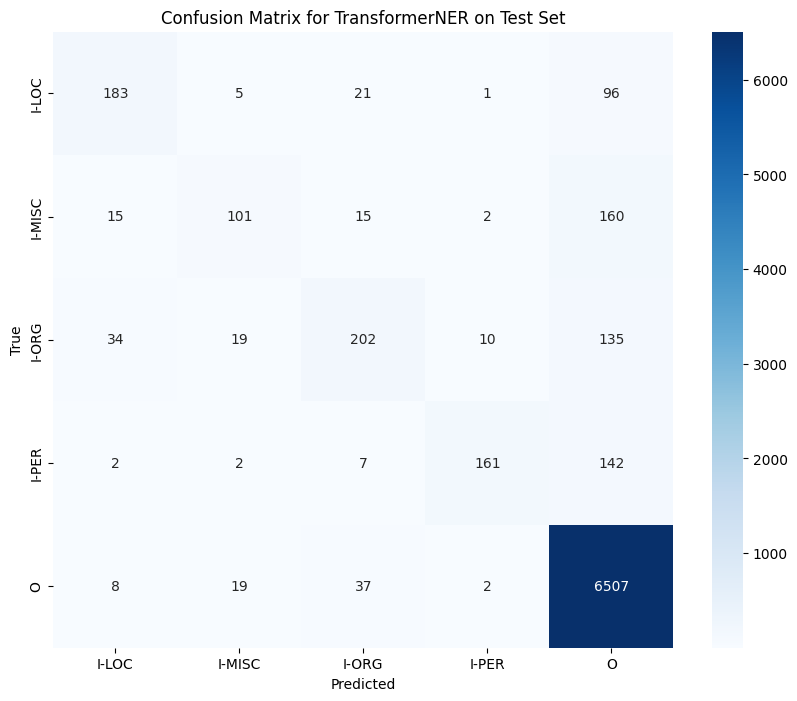

In [67]:
IdLabel = {0: '<PAD>', 1: 'I-LOC', 2: 'I-MISC', 3: 'I-ORG', 4: 'I-PER', 5: 'O'}
all_true_labels = []
all_pred_labels = []
correct = 0
total = 0
total_test_loss = 0
criterion = nn.CrossEntropyLoss(reduction='none')

# Evaluate on test set
with torch.no_grad():
    for PadWords, PadLabels, Lengths, Mask in TestDataLoader:
        PadWords, PadLabels = PadWords.to(device), PadLabels.to(device)
        Output = model(PadWords, Lengths)
        
        # Create active loss mask to ignore padded positions
        ActiveLoss = torch.ones_like(PadLabels, dtype=torch.bool)
        for i, Length in enumerate(Lengths):
            ActiveLoss[i, Length:] = False
        
        # Compute loss
        Loss = criterion(Output.view(-1, Output.size(-1)), PadLabels.view(-1))
        Loss = Loss[ActiveLoss.view(-1)].mean()
        total_test_loss += Loss.item()
        
        # Compute predictions
        _, Predicted = torch.max(Output, dim=-1)
        
        # Collect true and predicted labels for non-padded positions
        true_labels = PadLabels[ActiveLoss].cpu().numpy()
        pred_labels = Predicted[ActiveLoss].cpu().numpy()
        all_true_labels.extend(true_labels)
        all_pred_labels.extend(pred_labels)
        
        # Compute accuracy
        correct += ((Predicted == PadLabels) * ActiveLoss).sum().item()
        total += ActiveLoss.sum().item()

# Compute metrics
avg_test_loss = total_test_loss / len(TestDataLoader)
test_accuracy = correct / max(1, total)
precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels, all_pred_labels, average='weighted')

# Print metrics
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")

# Compute confusion matrix
valid_label_ids = [i for i in IdLabel.keys() if IdLabel[i] != '<PAD>']
label_names = [IdLabel[i] for i in valid_label_ids]
cm = confusion_matrix(all_true_labels, all_pred_labels, labels=valid_label_ids)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for TransformerNER on Test Set')
plt.show()